In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(X_train_full,y_train_full),(X_test,y_test) = keras.datasets.mnist.load_data()

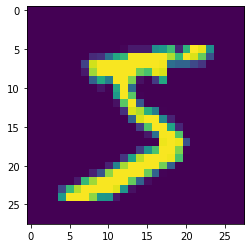

In [3]:
plt.imshow(X_train_full[0])

In [4]:
X_train_full.shape

(60000, 28, 28)

<h3> DNN Summary </h3> 

A DNN trained with 5 hiddens layers, 1 Flatten input layer

In [5]:
model_dnn = keras.models.Sequential()
model_dnn.add(keras.layers.Flatten(input_shape = [28,28]))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(5, activation="softmax"))

In [6]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5

Preparing the MNIST Data. 

First we shall only train on 0 to 4 digit labels, as we will use the rest for transfer learning.

In [7]:
def Prepdata0to4(X,y):
        y_data = y[np.where((y == 0) | (y == 1) | (y == 2)|(y == 3)| (y == 4))[0]]
        X_data = X[np.where((y == 0) | (y == 1) | (y == 2)|(y == 3)| (y == 4))[0]]
        return (X_data,y_data)

In [8]:
(X_data_0to4,y_data_0to4_sparse) = Prepdata0to4(X_train_full,y_train_full)

In [9]:
y_data_0to4 = keras.utils.to_categorical(y_data_0to4_sparse)
X_data_train0to4 = X_data_0to4[:25000]
y_data_train0to4 = y_data_0to4[:25000]
X_data_valid0to4 = X_data_0to4[25000:]
y_data_valid0to4 = y_data_0to4[25000:]

In [10]:
y_data_train0to4

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
X_data_valid0to4.shape

(5596, 28, 28)

In [12]:

(X_data_test0to4,y_data_test0to4_sparse) = Prepdata0to4(X_test,y_test)
y_data_test0to4 = keras.utils.to_categorical(y_data_test0to4_sparse)

In [13]:
y_data_test0to4_sparse

array([2, 1, 0, ..., 2, 3, 4], dtype=uint8)

In [14]:
#beta_1 is the momentum for moving mean of gradient
#beta_2 is the momentum for moving mean of squared gradient
adamoptim = keras.optimizers.Adam(lr = 0.001,beta_1=0.9,beta_2=0.999)
#callbacks to use
#checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("zerotofour.h5", save_best_only=True)
#early stopping callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [15]:
#metrics
accuracy = keras.metrics.CategoricalAccuracy(name = "categorical_accuracy")
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
aucscore = keras.metrics.AUC()

In [16]:
model_dnn.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim, 
                    metrics = [accuracy,precision,recall,aucscore])

In [17]:
X_data_train0to4.shape

(25000, 28, 28)

In [18]:
y_data_train0to4.shape

(25000, 5)

In [19]:
model_dnn_history1 = model_dnn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_cb,earlystopping_cb])

Epoch 1/40
782/782 [==============================] - 5s 4ms/step - loss: 4.9762 - categorical_accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9330 - val_loss: 0.3821 - val_categorical_accuracy: 0.9600 - val_precision: 0.9607 - val_recall: 0.9600 - val_auc: 0.9855
Epoch 2/40
782/782 [==============================] - 2s 3ms/step - loss: 0.2982 - categorical_accuracy: 0.9628 - precision: 0.9634 - recall: 0.9624 - auc: 0.9879 - val_loss: 0.2213 - val_categorical_accuracy: 0.9610 - val_precision: 0.9622 - val_recall: 0.9598 - val_auc: 0.9916
Epoch 3/40
782/782 [==============================] - 2s 3ms/step - loss: 0.1322 - categorical_accuracy: 0.9752 - precision: 0.9758 - recall: 0.9745 - auc: 0.9945 - val_loss: 0.1215 - val_categorical_accuracy: 0.9764 - val_precision: 0.9771 - val_recall: 0.9755 - val_auc: 0.9952
Epoch 4/40
782/782 [==============================] - 3s 3ms/step - loss: 0.0947 - categorical_accuracy: 0.9793 - precision: 0.9801 - recall: 0.9786 - auc: 0.99

In [20]:
#predicting on validation data, test data and making confusion matrices
y_pred_valid = np.argmax(model_dnn.predict(X_data_valid0to4),axis = 1)
y_pred_test = np.argmax(model_dnn.predict(X_data_test0to4),axis = 1)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,auc
confusion_matrix(y_data_0to4_sparse[25000:],y_pred_valid)

array([[1091,    0,    5,    3,    1],
       [   1, 1165,    3,    3,    3],
       [   4,    2, 1076,    6,    7],
       [   2,    0,   10, 1139,    0],
       [   1,    6,    3,    2, 1063]], dtype=int64)

In [22]:
 precision_score(y_data_0to4_sparse[25000:],y_pred_valid, average='weighted')

0.9889262703790644

In [23]:
recall_score(y_data_0to4_sparse[25000:],y_pred_valid, average='weighted')

0.9889206576125804

In [24]:
#on test data
confusion_matrix(y_data_test0to4_sparse,y_pred_test)

array([[ 976,    1,    1,    2,    0],
       [   1, 1126,    3,    2,    3],
       [   4,    2, 1017,    7,    2],
       [   0,    0,    6, 1003,    1],
       [   2,    1,    2,    1,  976]], dtype=int64)

In [25]:
 precision_score(y_data_test0to4_sparse,y_pred_test, average='weighted')

0.9920272021670881

In [26]:
recall_score(y_data_test0to4_sparse,y_pred_test, average='weighted')

0.9920217941233703

In [27]:
#learning curves for lr = 0.01, beta1 = 0.9, beta2 = 0.9994
import pandas as pd
model_dnn_history1_df = pd.DataFrame(data = model_dnn_history1.history)
model_dnn_history1_df

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,1.656940,0.92460,0.924668,0.92452,0.964845,0.382113,0.959971,0.960658,0.959971,0.985462
1,0.267266,0.96424,0.965077,0.96388,0.989245,0.221287,0.961044,0.962200,0.959793,0.991602
2,0.133944,0.97440,0.975126,0.97380,0.994646,0.121527,0.976412,0.977090,0.975518,0.995198
3,0.107750,0.97784,0.978806,0.97724,0.995881,0.252099,0.961222,0.961896,0.960865,0.989667
4,0.102506,0.97816,0.979124,0.97744,0.995959,0.169039,0.961222,0.962751,0.960686,0.993016
5,0.074220,0.98116,0.982558,0.98020,0.997650,0.092808,0.979450,0.980662,0.978735,0.996896
6,0.088305,0.98060,0.981998,0.97972,0.996873,0.102595,0.980879,0.982447,0.980164,0.996546
7,0.067376,0.98376,0.985158,0.98236,0.997805,0.097329,0.978199,0.981298,0.975161,0.997247
8,0.052944,0.98700,0.988762,0.98540,0.998451,0.143325,0.973910,0.976677,0.972838,0.995698
9,0.045897,0.98828,0.989539,0.98756,0.998595,0.084839,0.980879,0.982261,0.979628,0.997001


In [28]:
#number of layers is fixed, only thing being changed is learning rate, beta1, beta2
def validating_dnn_model_0to4(lr = 0.001, beta1 = 0.9, beta2 = 0.999):
    #set for only 5 hidden layers
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28,28]))
    for i in range(5):
        model.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(5, activation="softmax"))
    optim = keras.optimizers.Adam(lr = lr,beta_1=beta1,beta_2=beta2)
    accuracy = keras.metrics.CategoricalAccuracy(name = "categorical_accuracy")
    precision = keras.metrics.Precision()
    recall = keras.metrics.Recall()
    aucscore = keras.metrics.AUC()
    model.compile(loss = "categorical_crossentropy",
                    optimizer = optim, metrics = [accuracy,precision,recall,aucscore])
    return model

In [29]:
keras_dnn_model_0to4 = keras.wrappers.scikit_learn.KerasRegressor(validating_dnn_model_0to4)

In [30]:
checkpoint = keras.callbacks.ModelCheckpoint("zerotofour.h5", save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [32]:
""" scoring_dnn = {
    "Precision" : make_scorer(precision),
    "Accuracy" : make_scorer(accuracy), 
    "Recall" : make_scorer(recall), 
    "AUC" : make_scorer(aucscore)
} """

param_grid_dnn_0to4 = {
    'lr' : (0.0005,0.001, 0.005, 0.01, 0.05, 0.1),
    'beta1' : (0.4,0.5,0.6,0.7,0.8),
    'beta2' : (0.6,0.7,0.8,0.9,0.999)
}

In [33]:
rnd_search_dnn = RandomizedSearchCV(estimator = keras_dnn_model_0to4, param_distributions = param_grid_dnn_0to4, verbose = 2, return_train_score = True, n_iter = 10, random_state = 42)

In [34]:
rnd_search_dnn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [earlystopping])

cy: 0.1966 - val_precision_48: 0.1966 - val_recall_48: 0.1966 - val_auc_48: 0.4919
Epoch 28/40
625/625 [==============================] - 2s 3ms/step - loss: 2.3257 - categorical_accuracy: 0.1988 - precision_48: 0.2047 - recall_48: 0.1216 - auc_48: 0.5008 - val_loss: 1.8577 - val_categorical_accuracy: 0.2057 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_auc_48: 0.4981
Epoch 29/40
625/625 [==============================] - 2s 3ms/step - loss: 2.3190 - categorical_accuracy: 0.2051 - precision_48: 0.2038 - recall_48: 0.1093 - auc_48: 0.4975 - val_loss: 2.5136 - val_categorical_accuracy: 0.2100 - val_precision_48: 0.2100 - val_recall_48: 0.2100 - val_auc_48: 0.5087
Epoch 30/40
625/625 [==============================] - 2s 3ms/step - loss: 2.3190 - categorical_accuracy: 0.2017 - precision_48: 0.1991 - recall_48: 0.1224 - auc_48: 0.5018 - val_loss: 2.7721 - val_categorical_accuracy: 0.2100 - val_precision_48: 0.2100 - val_recall_48: 0.2100 - val_auc_48: 0.5013
Epoch 31/40


RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C05A83A700>,
                   param_distributions={'beta1': (0.4, 0.5, 0.6, 0.7, 0.8),
                                        'beta2': (0.6, 0.7, 0.8, 0.9, 0.999),
                                        'lr': (0.0005, 0.001, 0.005, 0.01, 0.05,
                                               0.1)},
                   random_state=42, return_train_score=True, verbose=2)

In [35]:
 rnd_search_dnn.best_params_

{'lr': 0.001, 'beta2': 0.8, 'beta1': 0.6}

In [36]:
rnd_search_dnn.cv_results_

{'mean_fit_time': array([32.75271773, 32.43710179, 25.65372987, 37.42000856, 33.21796966,
        28.3749166 , 27.71122794, 22.19677591, 27.11777844, 43.42659822]),
 'std_fit_time': array([ 5.33491148,  3.26283983,  4.74198269,  6.26001514, 13.52386555,
         2.19602071,  4.48157224,  1.26385179,  2.61978978, 11.30985642]),
 'mean_score_time': array([0.30502491, 0.30645685, 0.3563509 , 0.31166754, 0.32600675,
        0.31496406, 0.31831031, 0.31927018, 0.38856263, 0.36161308]),
 'std_score_time': array([0.01811554, 0.01206157, 0.08285917, 0.01716342, 0.0247986 ,
        0.02203001, 0.03059319, 0.01544814, 0.04124285, 0.00553426]),
 'param_lr': masked_array(data=[0.001, 0.0005, 0.05, 0.0005, 0.05, 0.001, 0.05, 0.01,
                    0.005, 0.05],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_beta2': masked_array(data=[0.8, 0.9, 0.999, 0.9, 0.8, 0.6, 0.6, 0.9

In [37]:
#y_pred_valid = np.argmax(model_dnn.predict(X_data_valid0to4),axis = 1)
#y_pred_test = np.argmax(model_dnn.predict(X_data_test0to4),axis = 1)
y_pred_tuned = np.argmax(rnd_search_dnn.best_estimator_.predict(X_data_test0to4),axis = 1)

precision_score(y_data_test0to4_sparse,y_pred_tuned, average='weighted')

0.9842988024153301

In [38]:
recall_score(y_data_test0to4_sparse,y_pred_tuned, average='weighted')

0.9842381786339754

In [39]:
model_tuned = keras.models.Sequential()
model_tuned.add(keras.layers.Flatten(input_shape = [28,28]))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(5, activation="softmax"))

In [40]:
adamoptim_tuned = keras.optimizers.Adam(lr = 0.001,beta_1=0.6,beta_2=0.8)
checkpoint_tuned = keras.callbacks.ModelCheckpoint('tuned0to4.h5',save_best_only=True)
earlystopping_tuned = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [41]:
model_tuned.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim_tuned, 
                    metrics = [accuracy,precision,recall,aucscore])

In [42]:
model_tuned_history = model_tuned.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_tuned,earlystopping_tuned])

Epoch 1/40
782/782 [==============================] - 4s 3ms/step - loss: 5.1798 - categorical_accuracy: 0.9330 - precision: 0.9333 - recall: 0.9328 - auc: 0.9655 - val_loss: 0.5134 - val_categorical_accuracy: 0.9382 - val_precision: 0.9390 - val_recall: 0.9376 - val_auc: 0.9785
Epoch 2/40
782/782 [==============================] - 2s 3ms/step - loss: 0.3660 - categorical_accuracy: 0.9592 - precision: 0.9596 - recall: 0.9590 - auc: 0.9866 - val_loss: 0.2537 - val_categorical_accuracy: 0.9650 - val_precision: 0.9665 - val_recall: 0.9650 - val_auc: 0.9903
Epoch 3/40
782/782 [==============================] - 2s 3ms/step - loss: 0.1941 - categorical_accuracy: 0.9703 - precision: 0.9709 - recall: 0.9698 - auc: 0.9928 - val_loss: 0.1347 - val_categorical_accuracy: 0.9800 - val_precision: 0.9803 - val_recall: 0.9796 - val_auc: 0.9956
Epoch 4/40
782/782 [==============================] - 2s 3ms/step - loss: 0.1592 - categorical_accuracy: 0.9775 - precision: 0.9782 - recall: 0.9769 - auc: 0.99

In [43]:
y_pred_tuned_final_test = np.argmax(model_tuned.predict(X_data_test0to4),axis = 1)

precision_score(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_final_test, average='weighted')

0.9868344594361041

In [44]:
y_data_test0to4

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [45]:
final_model = keras.models.load_model('tuned0to4.h5')

In [46]:
#learning curve for the tuned model
history_tuned = pd.DataFrame(model_tuned_history.history)
history_tuned

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,1.887910,0.937083,0.937443,0.936953,0.969833,0.513395,0.938170,0.938976,0.937634,0.978536
1,0.321786,0.961920,0.962414,0.961760,0.987931,0.253745,0.964975,0.966529,0.964975,0.990284
2,0.181615,0.972200,0.973318,0.971800,0.993205,0.134718,0.979986,0.980329,0.979628,0.995648
3,0.151655,0.977480,0.978290,0.976960,0.994495,0.117492,0.981951,0.982466,0.981237,0.996170
4,0.125347,0.981000,0.981779,0.980640,0.995320,0.152566,0.981951,0.982466,0.981237,0.995003
5,0.128497,0.981680,0.982852,0.981240,0.996115,0.146506,0.984453,0.985684,0.984275,0.996316
6,0.117904,0.985320,0.986222,0.984920,0.996531,0.221072,0.981058,0.982987,0.980879,0.995971
7,0.100642,0.986680,0.987617,0.985800,0.996506,0.164553,0.981951,0.983527,0.981594,0.994407
8,0.108197,0.987000,0.987704,0.986400,0.997050,0.098602,0.984989,0.986566,0.984275,0.997216
9,0.118245,0.989240,0.989829,0.988800,0.997342,0.085806,0.986419,0.988706,0.985525,0.997046


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

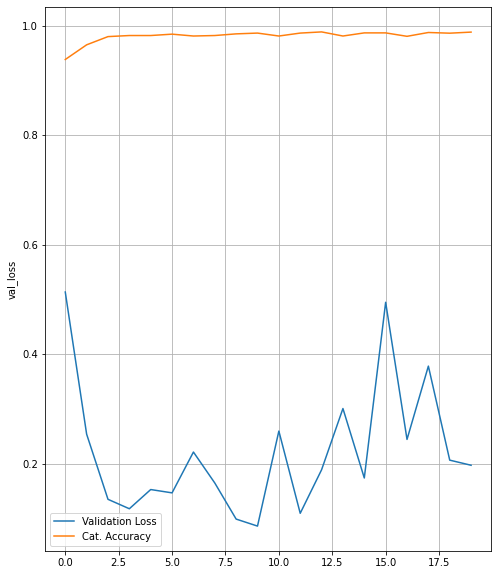

In [48]:
fig,ax_tuned = plt.subplots(1,1,figsize = (8,10))
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_loss"], label = "Validation Loss", ax = ax_tuned)
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_categorical_accuracy"], label = "Cat. Accuracy", ax = ax_tuned)
ax_tuned.legend()
ax_tuned.grid()

In [49]:
#adding batch Normalization layer to the above model
#Batch Normalization allows us to train with higher learning rates 
model_tuned_bn = keras.models.Sequential()
model_tuned_bn.add(keras.layers.Flatten(input_shape = [28,28]))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.Dense(5, activation="softmax"))

In [50]:
adamoptim_tuned_bn = keras.optimizers.Adam(lr = 0.001,beta_1=0.6,beta_2=0.8)
checkpoint_tuned_bn = keras.callbacks.ModelCheckpoint('tuned0to4bn.h5',save_best_only=True)
earlystopping_tuned_bn = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

model_tuned_bn.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim_tuned_bn, 
                    metrics = [accuracy,precision,recall,aucscore])

In [51]:
model_tuned_bn.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_53 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_318 (Dense)            (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_319 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_320 (Dense)            (None, 100)             

In [52]:
model_tuned_bn_history = model_tuned_bn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_tuned_bn,earlystopping_tuned_bn])

Epoch 1/40
782/782 [==============================] - 6s 5ms/step - loss: 0.2213 - categorical_accuracy: 0.9600 - precision: 0.9662 - recall: 0.9549 - auc: 0.9952 - val_loss: 0.0901 - val_categorical_accuracy: 0.9811 - val_precision: 0.9828 - val_recall: 0.9796 - val_auc: 0.9974
Epoch 2/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0667 - categorical_accuracy: 0.9795 - precision: 0.9810 - recall: 0.9781 - auc: 0.9983 - val_loss: 0.0650 - val_categorical_accuracy: 0.9878 - val_precision: 0.9887 - val_recall: 0.9868 - val_auc: 0.9983
Epoch 3/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0470 - categorical_accuracy: 0.9859 - precision: 0.9871 - recall: 0.9855 - auc: 0.9989 - val_loss: 0.0969 - val_categorical_accuracy: 0.9850 - val_precision: 0.9857 - val_recall: 0.9845 - val_auc: 0.9972
Epoch 4/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0422 - categorical_accuracy: 0.9869 - precision: 0.9875 - recall: 0.9863 - auc: 0.99

In [53]:
history_tuned_bn = pd.DataFrame(model_tuned_bn_history.history)
history_tuned_bn

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,0.133981,0.96323,0.967827,0.959603,0.996179,0.090141,0.981058,0.982790,0.979628,0.997384
1,0.066142,0.97956,0.980831,0.978320,0.998322,0.065010,0.987848,0.988720,0.986776,0.998261
2,0.047314,0.98580,0.986663,0.985440,0.998824,0.096938,0.984989,0.985686,0.984453,0.997204
3,0.042085,0.98728,0.987590,0.986760,0.998978,0.106703,0.986776,0.987835,0.986776,0.997823
4,0.035435,0.99020,0.990553,0.989840,0.998957,0.071202,0.988742,0.989092,0.988385,0.997831
5,0.030832,0.99084,0.991195,0.990680,0.999136,0.120154,0.988027,0.988372,0.987312,0.997741
6,0.027134,0.99124,0.991634,0.990960,0.999371,0.171206,0.988206,0.988732,0.987848,0.997399
7,0.023417,0.99320,0.993517,0.993040,0.999389,0.162539,0.985347,0.985520,0.985168,0.996742
8,0.023892,0.99300,0.993079,0.992880,0.999365,0.193776,0.988027,0.988023,0.987670,0.997110
9,0.018556,0.99424,0.994359,0.994200,0.999497,0.121376,0.984989,0.985694,0.984989,0.996563


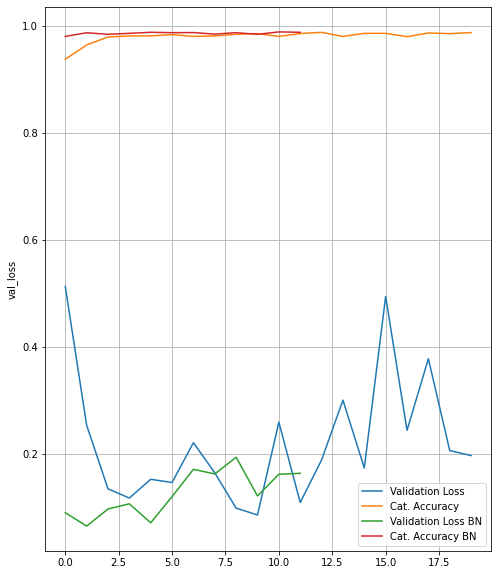

In [54]:
fig,ax_tuned = plt.subplots(1,1,figsize = (8,10))
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_loss"], label = "Validation Loss", ax = ax_tuned)
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_categorical_accuracy"], label = "Cat. Accuracy", ax = ax_tuned)

sns.lineplot(x = history_tuned_bn.index.values.tolist(), y = history_tuned_bn["val_loss"], label = "Validation Loss BN", ax = ax_tuned)
sns.lineplot(x = history_tuned_bn.index.values.tolist(), y = history_tuned_bn["val_categorical_accuracy"], label = "Cat. Accuracy BN", ax = ax_tuned)

ax_tuned.legend()
ax_tuned.grid()

Batch Normalization makes it much faster to train your model. Using just one epoch, we have achieved the a higher accuracy that without BN

In [55]:
y_pred_tuned_bn_final_test = np.argmax(model_tuned_bn.predict(X_data_test0to4),axis = 1)

precision_score(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_bn_final_test, average='weighted')

0.9889326914966761

BN also gives better Precision 

In [56]:
confusion_matrix(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_bn_final_test)

array([[ 975,    1,    0,    2,    2],
       [   0, 1133,    2,    0,    0],
       [   6,    5, 1011,    8,    2],
       [   0,    2,    5, 1003,    0],
       [   2,    3,   11,    6,  960]], dtype=int64)